# Homework nr. 3 - features transformation & selection (deadline 22/11/2018)

In short, the main task is to play with transformations and feature selection methods in order to obtain the best results for linear regression model predicting house sale prices.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can. ;)

## What are you supposed to do

Your aim is to optimize the _RMSLE_ (see the note below) of the linear regression estimator (=our prediction model) of the observed sale prices.

### Instructions:

  1. Download the dataset from the course pages (hw3_data.csv, hw3_data_description.txt). It corresponds to [this Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).
  2. Split the dataset into train & test part exactly as we did in the tutorial.
  3. Transform the features properly (don't forget the target variable).
  4. Try to find the best subset of features.
  5. Compare your results with the [Kaggle leaderboard](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard). You should be able to reach approximately the top 20% there.
  
Give comments on each step of your solution, with short explanations of your choices.

  
**Note**: _RMSLE_ is a Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sale prices.


## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, he can give you another chance to rework your homework and to obtain more points.

# Init

In [1]:
import numpy as np
import pandas as pd

from scipy import stats, optimize

from sklearn import model_selection, linear_model, metrics, preprocessing, feature_selection

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, skew #for some statistics

%matplotlib inline

def linreg(train, validate, plot = False, train_error = True):
    # Data prepare
    X = train.drop(['SalePrice'], axis = 1, errors = 'ignore')
    y = train.SalePrice
    Xv = validate.drop(['SalePrice'], axis = 1, errors = 'ignore')
    yv = validate.SalePrice
    
    # Linear Regression train
    clf = linear_model.LinearRegression()
    clf.fit(X, y) 
    
    # Print RMSE
    print('Linear regression root mean squared validation error:', 
          np.sqrt(metrics.mean_squared_error(clf.predict(Xv),yv)))
    if train_error:
        print('Linear regression root mean squared train error:', 
              np.sqrt(metrics.mean_squared_error(clf.predict(X), y)))
    
    # Joint Plot
    if plot:
        sns.jointplot(yv, clf.predict(Xv))

In [2]:
df = pd.read_csv('hw3_data.csv')

# Adding an important feature - Total Square Feet
As it is suggested in the link here: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard/notebook

In [3]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

# SalePrice analysis
Let's see what we deal with.

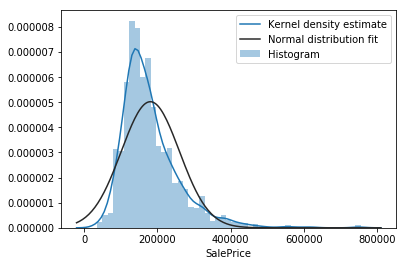

In [4]:
sns.distplot(df.SalePrice, 
             fit=stats.norm,  # It should be fitted by the normal distribution
             hist_kws = {'label': 'Histogram'},
             kde_kws = {'label': 'Kernel density estimate'},
             fit_kws = {'label': 'Normal distribution fit'},
            )
plt.legend()

### Log Transformation 

From the plots above, it can be seen that column SalePrice is a bit skewed and definitely not normally distributed. The data should be tranformed into normal distribution, because the linear regression gives better results for normally distributed data.

In [5]:
df["SalePrice"] = np.log1p(df["SalePrice"])

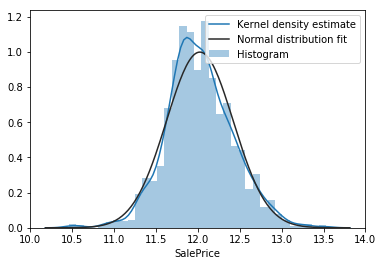

In [6]:
sns.distplot(df.SalePrice, 
             fit=stats.norm,  # It should be fitted by the normal distribution
             hist_kws = {'label': 'Histogram'},
             kde_kws = {'label': 'Kernel density estimate'},
             fit_kws = {'label': 'Normal distribution fit'},
            )
plt.legend()

# Missing Values
Let's analyse columns by the amount of missing data. I was quite curios how much can imputing missing values affect the error of the linear regression. That is why I split this section and choose the better one at the end of this section. One approach is the one from courses, the second one is from one article on kaggle. Basically, the second approach hugely inspired by the article.

In [7]:
df_one = df.copy()
df_two = df.copy()

## 1st approach - the one from our courses

### Transformations
The same operation we did at courses.

In [8]:
# Convert all object values to categorial format
df_one[df_one.select_dtypes(include=['object']).columns] = df_one.select_dtypes(include=['object']).apply(pd.Series.astype, dtype='category')

## Imputing missing values

In [9]:
# Fill all NaN with 0
df_one.loc[:,df_one.select_dtypes(include=['float64']).columns] = df_one.loc[:,df_one.select_dtypes(include=['float64']).columns].fillna(0)

In [10]:
df_one.columns[df_one.isnull().any()]

Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')

In [11]:
df_one = pd.get_dummies(df_one)

In [12]:
df_one.columns[df_one.isnull().any()]

Index([], dtype='object')

## 2nd approach - inspect every feature

In [13]:
df_two.columns[df_two.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

The dataset has 19 columns with missing values, but the model should be prepared that every column could have missing value.

### Imputing missing values
Inspired by https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard/notebook
I just wanted to try something else than what we did in the course.

In [14]:
df_two["PoolQC"] = df_two["PoolQC"].fillna("None")
df_two["MiscFeature"] = df_two["MiscFeature"].fillna("None")
df_two["Alley"] = df_two["Alley"].fillna("None")
df_two["Fence"] = df_two["Fence"].fillna("None")
df_two["FireplaceQu"] = df_two["FireplaceQu"].fillna("None")
df_two["LotFrontage"] = df_two.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median())) # fill by median of neighborhood

df_two["GarageType"] = df_two["GarageType"].fillna("None")
df_two["GarageCond"] = df_two["GarageCond"].fillna("None")
df_two["GarageFinish"] = df_two["GarageFinish"].fillna("None")
df_two["GarageQual"] = df_two["GarageQual"].fillna("None")
df_two["GarageYrBlt"] = df_two["GarageYrBlt"].fillna(0)
df_two["GarageArea"] = df_two["GarageArea"].fillna(0)
df_two["GarageCars"] = df_two["GarageCars"].fillna(0)

df_two["BsmtFinType1"] = df_two["BsmtFinType1"].fillna("None")
df_two["BsmtFinType2"] = df_two["BsmtFinType2"].fillna("None")
df_two["BsmtExposure"] = df_two["BsmtExposure"].fillna("None")
df_two["BsmtQual"] = df_two["BsmtQual"].fillna("None")
df_two["BsmtCond"] = df_two["BsmtCond"].fillna("None")
df_two["BsmtFinSF1"] = df_two["BsmtFinSF1"].fillna(0)
df_two["BsmtFinSF2"] = df_two["BsmtFinSF2"].fillna(0)
df_two["BsmtUnfSF"] = df_two["BsmtUnfSF"].fillna(0)
df_two["TotalBsmtSF"] = df_two["TotalBsmtSF"].fillna(0)
df_two["BsmtFullBath"] = df_two["BsmtFullBath"].fillna(0)
df_two["BsmtHalfBath"] = df_two["BsmtHalfBath"].fillna(0)


df_two["MasVnrArea"] = df_two["MasVnrArea"].fillna("None")
df_two["MasVnrType"] = df_two["MasVnrType"].fillna("None")

df_two["MSZoning"] = df_two["MSZoning"].fillna(df_two['MSZoning'].mode()[0]) # far the most frequent value

df_two["Electrical"] = df_two["Electrical"].fillna("None")

df_two = df_two.drop(['Utilities'], axis=1) # this wont help in modeling

df_two["Functional"] = df_two["Functional"].fillna("Typ") # From description file - Assume typical unless deductions are warranted
df_two["Electrical"] = df_two["Electrical"].fillna(df_two["Electrical"].mode()[0])
df_two["KitchenQual"] = df_two["KitchenQual"].fillna(df_two["KitchenQual"].mode()[0])
df_two["Exterior1st"] = df_two["Exterior1st"].fillna(df_two["Exterior1st"].mode()[0])
df_two["Exterior2nd"] = df_two["Exterior2nd"].fillna(df_two["Exterior2nd"].mode()[0])
df_two["SaleType"] = df_two["SaleType"].fillna(df_two["SaleType"].mode()[0])
df_two["MSSubClass"] = df_two["MSSubClass"].fillna("None")



## Transforming column that should be categorial

In [15]:
cols = ('MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','OverallQual','OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature','MoSold','SaleType','SaleCondition')
for col in cols:
    df[col] = df[col].astype(str)

In [16]:
df_two = pd.get_dummies(df_two)

In [17]:
df_two.columns[df_two.isnull().any()]

Index([], dtype='object')

## So which one gives better results?

In [18]:
#split data into training and testing (validation) set
dt_one, dv_one = model_selection.train_test_split(df_one, test_size=0.25, random_state=17)
dt_one = dt_one.copy()
dv_one = dv_one.copy()

dt_two, dv_two = model_selection.train_test_split(df_two, test_size=0.25, random_state=17)
dt_two = dt_two.copy()
dv_two = dv_two.copy()

print('Train one: ', len(dt_one), '; Validation one: ', len(dv_one))
print('Train two: ', len(dt_two), '; Validation two: ', len(dv_two))
linreg(dt_one, dv_one)
linreg(dt_two, dv_two)

Train one:  1095 ; Validation one:  365
Train two:  1095 ; Validation two:  365
Linear regression root mean squared validation error: 0.13036815123583506
Linear regression root mean squared train error: 0.0905750878877585


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Linear regression root mean squared validation error: 0.14260299400930185
Linear regression root mean squared train error: 0.06849896402333105


# Standardization or Normalization

In [19]:
standard_scaler = preprocessing.StandardScaler()
minmax_scaler = preprocessing.MinMaxScaler()

#####################FOR 1st approach############################
columns_one = dt_one.select_dtypes(include=['float64']).columns 
columns_one = columns_one.drop('SalePrice', errors = 'ignore')
print('Columns to be standardized - one: ', list(columns_one))

standard_scaler.fit(dt_one[columns_one])
minmax_scaler.fit(dt_one[columns_one])

dt_one_s = dt_one.copy()
dv_one_s = dv_one.copy()
dt_one_s[columns_one] = standard_scaler.transform(dt_one_s[columns_one])
dv_one_s[columns_one] = standard_scaler.transform(dv_one_s[columns_one])

dt_one_m = dt_one.copy()
dv_one_m = dv_one.copy()
dt_one_m[columns_one] = minmax_scaler.transform(dt_one_m[columns_one])
dv_one_m[columns_one] = minmax_scaler.transform(dv_one_m[columns_one])
#####################FOR 2nd approach############################
columns_two = dt_two.select_dtypes(include=['float64']).columns 
columns_two = columns_two.drop('SalePrice', errors = 'ignore')
print('Columns to be standardized - two: ', list(columns_two))

standard_scaler.fit(dt_two[columns_two])
minmax_scaler.fit(dt_two[columns_two])

dt_two_s = dt_two.copy()
dv_two_s = dv_two.copy()
dt_two_s[columns_two] = standard_scaler.transform(dt_two_s[columns_two])
dv_two_s[columns_two] = standard_scaler.transform(dv_two_s[columns_two])

dt_two_m = dt_two.copy()
dv_two_m = dv_two.copy()
dt_two_m[columns_two] = minmax_scaler.transform(dt_two_m[columns_two])
dv_two_m[columns_two] = minmax_scaler.transform(dv_two_m[columns_two])

Columns to be standardized - one:  ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
Columns to be standardized - two:  ['LotFrontage', 'GarageYrBlt']


In [20]:
print("# NaNs to 0 - standartized")
linreg(dt_one_s, dv_one_s);
print("# NaNs are more inspected - standartized")
linreg(dt_two_s, dv_two_s);

print("# NaNs to 0 - MinMax")
linreg(dt_one_m, dv_one_m);
print("# NaNs are more inspected - MinMax")
linreg(dt_two_m, dv_two_m);


# NaNs to 0 - standartized
Linear regression root mean squared validation error: 0.13036815123584009
Linear regression root mean squared train error: 0.09057508788775831
# NaNs are more inspected - standartized
Linear regression root mean squared validation error: 0.14260299400931528
Linear regression root mean squared train error: 0.06849896402333107
# NaNs to 0 - MinMax
Linear regression root mean squared validation error: 0.1303681512358477
Linear regression root mean squared train error: 0.09057508788775849
# NaNs are more inspected - MinMax
Linear regression root mean squared validation error: 0.14260299400930343
Linear regression root mean squared train error: 0.06849896402333103


As it can be seen, dataset of NaNs to 0 with MinMax gives the lowest validation error.

In [21]:
dt = dt_one_m.copy()
dv = dv_one_m.copy()

### Removing ID
Id has no relevant correlation to data, so it is better to remove it.

In [22]:
columns_to_remove = ['Id']

### Removing columns based on low variance

In [23]:
columns_to_remove = list(set(list(dt.columns[dt.var() < 0.01]) + columns_to_remove))
print(columns_to_remove)

['Neighborhood_Veenker', 'Heating_OthW', 'SaleType_ConLw', 'GarageQual_Gd', 'SaleType_Oth', 'RoofMatl_Tar&Grv', 'Condition1_RRNn', 'LotConfig_FR3', 'BsmtFinType2_GLQ', 'Id', 'Exterior2nd_CBlock', 'GarageType_CarPort', 'Neighborhood_Blueste', 'PoolQC_Ex', 'BsmtCond_Po', 'Neighborhood_BrDale', 'GarageType_2Types', 'Condition2_RRAn', 'Neighborhood_NPkVill', 'Condition1_PosA', 'Condition2_RRNn', 'Exterior1st_BrkComm', 'Heating_Grav', 'Exterior1st_AsphShn', 'SaleCondition_AdjLand', 'LandSlope_Sev', 'RoofStyle_Flat', 'RoofStyle_Mansard', 'HeatingQC_Po', 'Functional_Maj2', 'RoofStyle_Gambrel', 'Electrical_Mix', 'Heating_Wall', 'MasVnrType_BrkCmn', 'Functional_Mod', 'HouseStyle_1.5Unf', 'SaleType_ConLD', 'RoofMatl_WdShake', 'PoolQC_Fa', 'Utilities_NoSeWa', 'Condition1_RRNe', 'ExterCond_Po', 'Exterior1st_Stone', 'Condition2_Feedr', 'Street_Grvl', 'Exterior1st_CBlock', 'RoofStyle_Shed', 'Condition1_RRAe', 'HouseStyle_2.5Fin', 'Foundation_Stone', 'Electrical_FuseP', 'Utilities_AllPub', 'Exterior2

### Removing columns based on low correlation

In [24]:
dtCopy = dt.copy()
X = dtCopy.drop(columns_to_remove, axis = 1, errors = 'ignore').drop(['SalePrice'], axis = 1, errors = 'ignore')
y = dtCopy.SalePrice
Fscores, pvals = feature_selection.f_regression(X,y)
pvals_result = pd.Series(pvals, index = X.columns)
additional_columns = list(pvals_result[pvals_result > 0.8].index)
print(additional_columns)
columns_to_remove = list(set(columns_to_remove + additional_columns))

['Exterior1st_Plywood']


### Final removal

In [25]:
dt.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)
dv.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)
dt.shape

(1095, 200)

In [26]:
linreg(dt, dv)

Linear regression root mean squared validation error: 0.1277617113218875
Linear regression root mean squared train error: 0.11104718129382724


# Comparison of my results with Kaggle leaderboard
My validation error is 0.12776, which is a place 1550 in the leaderboard.